## 1. Cargar los datos

Se importan éstas librerias para hacer un respectivo EDA.
Por temas de privacidad eliminaré la conectividad con la base de datos.

In [ ]:
import pandas as pd
import sqlalchemy as sa


class DatabaseConnection:

    def __init__(
        self,
        username: str,
        password: str,
        database: str = "##",
        host: str = "##",
        port: int = ##,
        dialect: str = "mysql",
        driver: str = "pymysql",
    ) -> None:
        """Creates a connection to a database

        Args:
            username (str): username
            password (str): password
            dialect (str, optional): dialect. Defaults to "mysql".
            driver (str, optional): driver. Defaults to "pymysql".
            host (str, optional): host. Defaults to "##".
            port (int, optional): port. Defaults to ##.
            database (str, optional): database. Defaults to "data".
        """
        connection_string = f"{dialect}+{driver}://{username}:{password}@{host}:{port}/{database}"
        self.engine = sa.create_engine(connection_string)

    def insert_dataframe(self, df: pd.DataFrame, table_name: str) -> None:
        """Inserts a dataframe into a table
        
        Args:
            df (pd.DataFrame): dataframe to insert
            table_name (str): table name
        """
        df.to_sql(table_name, self.engine, if_exists="replace", index=False)

    def query_to_df(self, query: str) -> pd.DataFrame:
        """Retrieves a dataframe from a query.

        Args:
            query (str): query to perform.

        Returns:
            pd.DataFrame: daframe with the results of the query.
        """
        with self.engine.connect() as conn:
            df = pd.read_sql_query(query, conn)
            return df

    def check_connection(self) -> bool:
        """Checks if the connection is working

        Returns:
            bool: True if the connection is working, False otherwise
        """
        try:
            self.engine.connect()
        except Exception as e:
            print(e)
            return False

Se cambia los valores para no mostrar valores sensibles.

In [ ]:
DB_USERNAME = "###"
DB_PASSWORD = "####"
LOCATION = (###, ###)

In [3]:
database = DatabaseConnection(DB_USERNAME, DB_PASSWORD)
database.check_connection()

In [4]:
query = """
    SELECT familia,
        articulo,
        fechaVenta AS fecha_venta,
        festivo,
        precio,
        cantidad,
        importe,
        orden_articulo_familia

    FROM jpra_ventas_diarias_estudio
"""


ventas = database.query_to_df(query)
ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10322 entries, 0 to 10321
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   familia                 10322 non-null  object 
 1   articulo                10322 non-null  object 
 2   fecha_venta             10322 non-null  object 
 3   festivo                 809 non-null    object 
 4   precio                  10322 non-null  float64
 5   cantidad                10322 non-null  float64
 6   importe                 10322 non-null  float64
 7   orden_articulo_familia  10322 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 645.3+ KB


In [5]:
## cambiamos el nombre de fecha a tipo fecha y articulo a tipo entero
ventas["fecha_venta"] = pd.to_datetime(ventas["fecha_venta"])
ventas["articulo"] = ventas["articulo"].astype(int)

In [6]:
ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10322 entries, 0 to 10321
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 10322 non-null  object        
 1   articulo                10322 non-null  int64         
 2   fecha_venta             10322 non-null  datetime64[ns]
 3   festivo                 809 non-null    object        
 4   precio                  10322 non-null  float64       
 5   cantidad                10322 non-null  float64       
 6   importe                 10322 non-null  float64       
 7   orden_articulo_familia  10322 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 645.3+ KB


### 1.1 Conectarse al API meteostat

Al conectarnos al API del clima nos dará algunas variables que lo utilizaremos para entrenar el modelo y ver si el tiempo afecta en los consumidores al momento de comprar.

Las variables que se obtienen:

- **tavg** -> The average air temperature in °C
- **tmin** -> The minimum air temperature in °C
- **tmax** -> The maximum air temperature in °C
- **prcp** -> The daily precipitation total in mm
- **wdir** -> The average wind direction in degrees (°)
- **wspd** -> The average wind speed in km/h
- **wpgt** -> The peak wind gust in km/h
- **pres** -> The average sea-level air pressure in hPa
- **tsun** -> The daily sunshine total in minutes (m)

Para conectarnos a esta API necesitamos la localización de la tienda, ya se guardó en la variable LOCATION

In [7]:
import numpy as np
import datetime
from meteostat import Point, Daily

# Columnas de clima importantes
IMP_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun']

def get_weather_df_filtered(start: datetime.datetime, end: datetime.datetime, location: tuple[float, float]) -> pd.DataFrame:
    lat, lon = location
    point = Point(lat, lon)
    df_weather = Daily(point, start, end).fetch().reset_index()
    return df_weather[["time"] + IMP_COLUMNS]  # solo columnas importantes

def add_weather_columns_filtered(
    ventas: pd.DataFrame,
    location: tuple[float, float],
    date_column_name: str = "fecha_venta",
) -> pd.DataFrame:
    start = ventas[date_column_name].min()
    end = ventas[date_column_name].max()
    weather_df = get_weather_df_filtered(start, end, location)
    return weather_df

In [8]:
weather_df = add_weather_columns_filtered(ventas, LOCATION)
weather_df.head()

,time,tavg,tmin,tmax,prcp,wdir,wspd,wpgt,pres,tsun
0,2021-05-01,17.2,11.9,22.8,0.0,<NA>,14.2,<NA>,1014.0,<NA>
1,2021-05-02,16.3,10.8,23.2,0.0,<NA>,15.7,<NA>,1015.9,<NA>
2,2021-05-03,15.3,12.7,20.1,6.5,<NA>,9.7,<NA>,1017.7,<NA>
3,2021-05-04,16.5,12.0,20.9,0.0,<NA>,12.1,<NA>,1018.0,<NA>
4,2021-05-05,16.7,12.3,21.7,0.0,<NA>,13.8,<NA>,1016.5,<NA>


In [9]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    730 non-null    datetime64[ns]
 1   tavg    730 non-null    Float64       
 2   tmin    730 non-null    Float64       
 3   tmax    730 non-null    Float64       
 4   prcp    723 non-null    Float64       
 5   wdir    0 non-null      Float64       
 6   wspd    730 non-null    Float64       
 7   wpgt    712 non-null    Float64       
 8   pres    730 non-null    Float64       
 9   tsun    0 non-null      Float64       
dtypes: Float64(9), datetime64[ns](1)
memory usage: 63.6 KB


Usando .info() y .head() se identificó que las columnas 'wdir' y 'tsun' no contiene datos, asi que se pasará a eliminar.

In [10]:
weather_df = weather_df.drop(columns=['wdir', 'tsun'])
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    730 non-null    datetime64[ns]
 1   tavg    730 non-null    Float64       
 2   tmin    730 non-null    Float64       
 3   tmax    730 non-null    Float64       
 4   prcp    723 non-null    Float64       
 5   wspd    730 non-null    Float64       
 6   wpgt    712 non-null    Float64       
 7   pres    730 non-null    Float64       
dtypes: Float64(7), datetime64[ns](1)
memory usage: 50.7 KB


In [11]:
df = pd.merge(
    ventas,
    weather_df,
    left_on=["fecha_venta"],
    right_on="time",
    how="inner").drop("time", axis=1)

df.sort_values(["articulo", "fecha_venta"], inplace=True)

df.reset_index(inplace=True, drop=True)

df.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg,tmin,tmax,prcp,wspd,wpgt,pres
0,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736004,5,17.2,11.9,22.8,0.0,14.2,<NA>,1014.0
1,PANADERIA,417,2021-05-02,Día de la Madre,4.038,81.0,327.077995,5,16.3,10.8,23.2,0.0,15.7,<NA>,1015.9
2,PANADERIA,417,2021-05-03,Día de la Cruz,4.038,90.0,363.419998,5,15.3,12.7,20.1,6.5,9.7,<NA>,1017.7
3,PANADERIA,417,2021-05-04,None,4.038,84.0,339.192001,5,16.5,12.0,20.9,0.0,12.1,<NA>,1018.0
4,PANADERIA,417,2021-05-05,None,4.038,84.0,339.192003,5,16.7,12.3,21.7,0.0,13.8,<NA>,1016.5


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10322 entries, 0 to 10321
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 10322 non-null  object        
 1   articulo                10322 non-null  int64         
 2   fecha_venta             10322 non-null  datetime64[ns]
 3   festivo                 809 non-null    object        
 4   precio                  10322 non-null  float64       
 5   cantidad                10322 non-null  float64       
 6   importe                 10322 non-null  float64       
 7   orden_articulo_familia  10322 non-null  int64         
 8   tavg                    10322 non-null  Float64       
 9   tmin                    10322 non-null  Float64       
 10  tmax                    10322 non-null  Float64       
 11  prcp                    10225 non-null  Float64       
 12  wspd                    10322 non-null  Float6

## 2. Preguntas

#### 2.1 Describe que significa cada fila de nuestro conjunto de datos.

In [13]:
df.describe(include='all')

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg,tmin,tmax,prcp,wspd,wpgt,pres
count,10322,10322.000000,10322,809,10322.000000,10322.000000,10322.000000,10322.000000,10322.0,10322.0,10322.0,10225.0,10322.0,10067.0,10322.0
unique,3,NaN,NaN,26,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
top,PANADERIA,NaN,NaN,Feria de Málaga,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
freq,3650,NaN,NaN,99,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
mean,NaN,3945.385197,2022-04-29 14:56:20.275140608,NaN,15.398333,138.310118,462.617803,2.961538,19.373164,15.195786,24.894371,0.794455,14.354524,29.991348,1018.058555
min,NaN,417.000000,2021-05-01 00:00:00,NaN,0.865000,1.200000,9.000000,1.000000,7.3,1.1,13.3,0.0,6.1,16.7,1004.4
25%,NaN,1043.000000,2021-10-28 00:00:00,NaN,2.591000,15.000000,288.000000,2.000000,14.5,10.8,19.6,0.0,10.9,25.9,1014.5
50%,NaN,5403.000000,2022-04-29 00:00:00,NaN,3.545000,84.000000,405.059754,3.000000,19.3,14.6,24.7,0.0,12.5,29.6,1017.3
75%,NaN,6286.000000,2022-10-29 00:00:00,NaN,34.091000,219.000000,569.453926,4.000000,23.9,20.1,29.6,0.0,16.9,33.3,1021.0
max,NaN,6549.000000,2023-04-30 00:00:00,NaN,43.500000,1110.000000,3271.929962,5.000000,33.5,27.5,42.6,46.8,46.5,55.5,1032.8


#### 2.2 ¿Cuántos valores únicos hay en cada una de las variables? ¿Qué insight podrías observar al comparar los valores únicos de la variable "articulo" con los valores únicos de la variable "precio"?

Para conocer los valores únicos de cada variable se creará una variable summary para agregar las siguientes columnas:

- Cardinalidad: Para ver los valores únicos
- Granularidad: Para poder identificar qué columnas nos puede ayudar para los modelos y qué usar.
- Nulos_Pct: Es para saber el porcentaje de nulos.

In [14]:
# Cambiamos los tipo de valores en las columnas familia y festivo, para poder trabajar con ellos como categóricos
df['familia'] = df['familia'].astype(str)
df['festivo'] = df['festivo'].astype(str)

In [15]:
# Calculando valores únicos, se crea una variable llamada summary para agregar columnas de cardinalidad y granularidad.
summary = (
    df.dtypes.to_frame("Tipo")
    .assign(Cardinalidad = df.nunique())
    .assign(Granularidad = df.nunique() / len(df) * 100)
    .assign(Nulos_Pct = df.isnull().sum() / len(df) * 100)
)


In [16]:
# Calcular máximos y mínimos por separado y unirlos
max_vals = df.max(numeric_only=False).rename("Max")
min_vals = df.min(numeric_only=False).rename("Min")

# Unir todo
summary = summary.join([max_vals, min_vals])

In [17]:
# Conocer valores únicos por variables, agregando porcentajes de nulos y maximos y minimos
summary.sort_values("Tipo", key=lambda col: col.astype(str))

,Tipo,Cardinalidad,Granularidad,Nulos_Pct,Max,Min
tavg,Float64,200,1.937609,0.000000,33.5,7.3
tmin,Float64,212,2.053866,0.000000,27.5,1.1
tmax,Float64,220,2.131370,0.000000,42.6,13.3
prcp,Float64,58,0.561907,0.939740,46.8,0.0
wspd,Float64,196,1.898857,0.000000,46.5,6.1
wpgt,Float64,22,0.213137,2.470451,55.5,16.7
pres,Float64,217,2.102306,0.000000,1032.8,1004.4
fecha_venta,datetime64[ns],730,7.072273,0.000000,2023-04-30 00:00:00,2021-05-01 00:00:00
precio,float64,45,0.435962,0.000000,43.5,0.865
cantidad,float64,1388,13.447006,0.000000,1110.0,1.2


Se observa que los valores únicos de precio y artículo varia, para saber si existe una relación con las fechas, se agrupará por fecha, para conocer cuántas veces cambió el precio de un artículo, se agrupa la fecha de venta por año y artículo

In [18]:
df.groupby([df['fecha_venta'].dt.year, 'articulo'])['precio'].nunique().unstack()

articulo,417,900,968,1043,1084,3880,3960,5403,5404,5803,6286,6425,6451,6523,6549
fecha_venta,,,,,,,,,,,,,,,
2021,2,1,3,3,1,2,2,2,2,2,2,6,2,2,2
2022,2,1,2,2,2,3,2,3,3,2,3,2,2,3,2
2023,1,1,1,1,1,1,2,1,1,1,2,1,1,1,1


Se demuestra que en los años 2021 y 2022 hubo cambios de precios de los artículos, en el 2023 no se puede saber con claridad ya que solo tenemos datos hasta abril.

### 2.3 ¿Cuántos valores nulos hay en cada una de las variables?

Usaremos la librería missingno que ayuda a poder visualizar los datos nulos.

<Axes: >

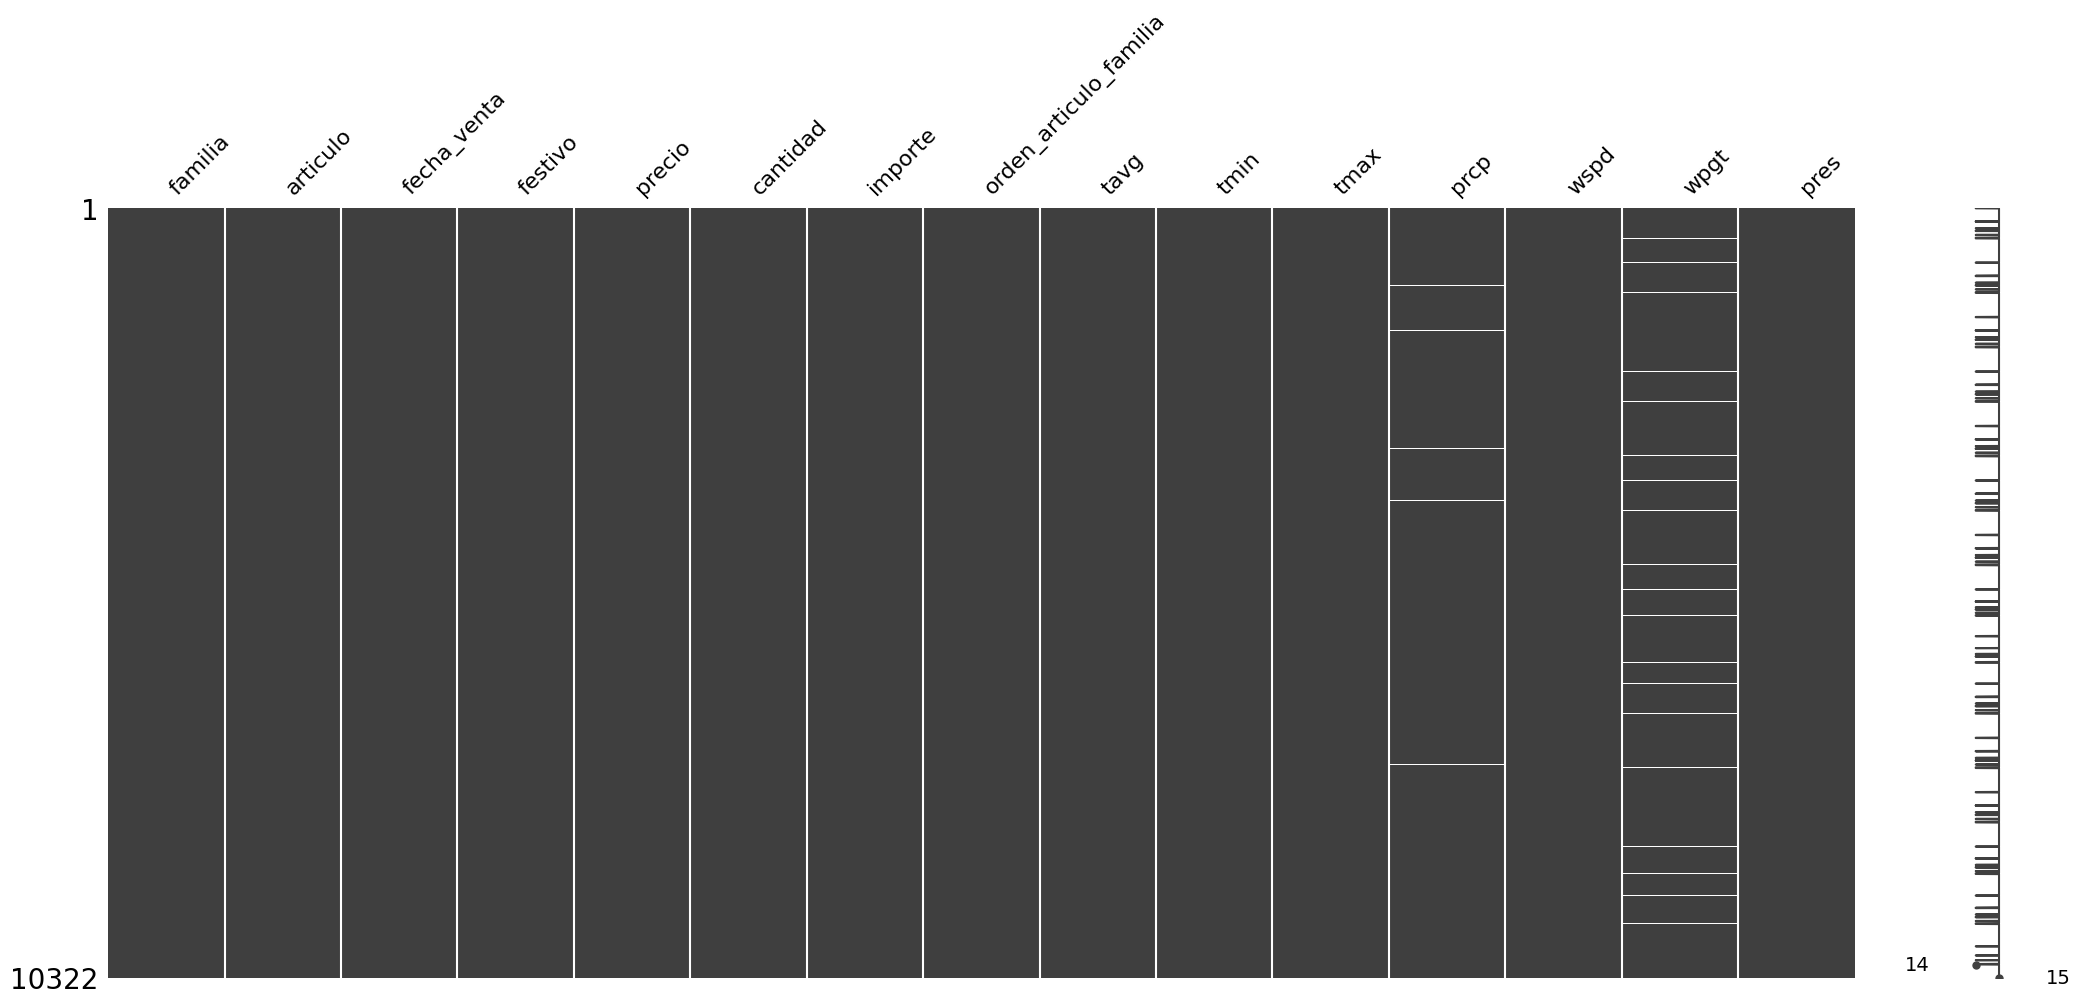

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

msno.matrix(df)

Nota: La columna de festivo se ve completa porque al cambiarse como string, los valores nulos se volvieron a valores string.

### 2.4 ¿Hay duplicados?

Usaremos las variables de fecha_venta, articulo e importe, si existe duplicados.

In [20]:
df[df.duplicated(['fecha_venta', 'articulo', 'importe'], keep=False)]

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg,tmin,tmax,prcp,wspd,wpgt,pres


No existen valores duplicados.

### 2.5 ¿Cuál es el rango de fechas de nuestro conjunto de datos? Si se divide por producto, ¿hay fechas faltantes?

In [21]:
# Rango de fechas del conjunto de datos

min_date = df['fecha_venta'].min()
max_date = df['fecha_venta'].max()

print(f"El conjunto de datos contiene valores desde {min_date} hasta {max_date}. ",
      f"Lo que supone {max_date - min_date}")

El conjunto de datos contiene valores desde 2021-05-01 00:00:00 hasta 2023-04-30 00:00:00.  Lo que supone 729 days 00:00:00


La tabla que se conectó en la query fue el que se llama jpra_ventas_diarias_estudio y este tiene una división entre el 01/05/2021 hasta el 30/04/2023

In [22]:
# Fechas faltantes

unique_articles = df.sort_values("familia")["articulo"].unique().tolist()
complete_range = pd.date_range(start=min_date, end=max_date, freq='D')

for article in unique_articles:

    subset = df.query("articulo == @article")
    family = subset["familia"].unique().tolist()[0]

    missing_dates = complete_range.difference(subset['fecha_venta'])

    print(family, "-> Articulo", article, "-> Fechas faltantes", len(missing_dates))

BOLLERIA -> Articulo 3960 -> Fechas faltantes 0
BOLLERIA -> Articulo 5803 -> Fechas faltantes 3
BOLLERIA -> Articulo 3880 -> Fechas faltantes 0
BOLLERIA -> Articulo 6286 -> Fechas faltantes 2
BOLLERIA -> Articulo 6425 -> Fechas faltantes 1
PANADERIA -> Articulo 1084 -> Fechas faltantes 0
PANADERIA -> Articulo 417 -> Fechas faltantes 0
PANADERIA -> Articulo 900 -> Fechas faltantes 0
PANADERIA -> Articulo 968 -> Fechas faltantes 0
PANADERIA -> Articulo 1043 -> Fechas faltantes 0
PASTELERIA -> Articulo 6451 -> Fechas faltantes 73
PASTELERIA -> Articulo 6549 -> Fechas faltantes 304
PASTELERIA -> Articulo 6523 -> Fechas faltantes 48
PASTELERIA -> Articulo 5403 -> Fechas faltantes 103
PASTELERIA -> Articulo 5404 -> Fechas faltantes 94


Nota: Las fechas faltantes por artículo no supone problema porque indica que no siempre se vende los mismos artículos todos os días.

Se usa la libreria de plotly.express porque se puede hacer hover sobre los puntos para ver valores exactos, zoom en rangos de fechas

Nota: Para ejecutar el siguiente código se ha instalado kaleido para poder renderizar las imágenes generadas por la librería plotly. La versión que se usa se puede ver en requirements.txt

In [ ]:
import plotly.express as px
from pathlib import Path

# 0. Definir el rango completo de fechas (FALTA ESTO EN TU CÓDIGO)
complete_range = pd.date_range(
    start=df['fecha_venta'].min(),  
    end=df['fecha_venta'].max(),    
    freq='D'                        
)

# 1. Configuración inicial
output_folder = "graficos"
Path(output_folder).mkdir(exist_ok=True)

# 2. Lista de artículos
articulos = [3960, 5803, 3880, 6286, 6425, 1084, 417, 900, 968, 1043, 6451, 6549, 6523, 5403, 5404]

# 3. Bucle para cada artículo
for articulo in articulos:
    # Filtrar y verificar si hay datos
    filtered_df = df.query("articulo == @articulo")
    if filtered_df.empty:
        print(f"⚠️ No hay datos para el artículo {articulo}. Saltando...")
        continue
    
    # Preparar datos
    filtered_df = filtered_df.set_index("fecha_venta").reindex(complete_range)
    filtered_df["articulo"] = filtered_df["articulo"].ffill()

    # Crear gráfico
    fig = px.line(
        filtered_df,
        x=filtered_df.index,
        y="cantidad",
        title=f"Ventas del Artículo {articulo}",
        labels={"cantidad": "Unidades Vendidas", "fecha_venta": "Fecha"},
        color_discrete_sequence=["skyblue"],
        template="simple_white"
    )
    fig.update_layout(
        xaxis_title="Fecha de Venta",
        yaxis_title="Cantidad Vendida",
        hovermode="x"
    )

    # Guardar imagen
    output_path = f"{output_folder}/ventas_articulo_{articulo}.png"
    fig.write_image(output_path, scale=2)  # scale=2 para mejor resolución
    print(f"✅ Gráfico guardado: {output_path}")
    
    fig.show()  # Mostrar gráfico

✅ Gráfico guardado: graficos/ventas_articulo_3960.png


✅ Gráfico guardado: graficos/ventas_articulo_5803.png


✅ Gráfico guardado: graficos/ventas_articulo_3880.png


✅ Gráfico guardado: graficos/ventas_articulo_6286.png


✅ Gráfico guardado: graficos/ventas_articulo_6425.png


✅ Gráfico guardado: graficos/ventas_articulo_1084.png


✅ Gráfico guardado: graficos/ventas_articulo_417.png


✅ Gráfico guardado: graficos/ventas_articulo_900.png


✅ Gráfico guardado: graficos/ventas_articulo_968.png


✅ Gráfico guardado: graficos/ventas_articulo_1043.png


✅ Gráfico guardado: graficos/ventas_articulo_6451.png


✅ Gráfico guardado: graficos/ventas_articulo_6549.png


✅ Gráfico guardado: graficos/ventas_articulo_6523.png


✅ Gráfico guardado: graficos/ventas_articulo_5403.png


✅ Gráfico guardado: graficos/ventas_articulo_5404.png


### 2.6 Separando por producto, ¿hay outliers en la variable "cantidad"?

In [25]:
outliers_report = []

for (family, article), group in df.groupby(['familia', 'articulo']):
    Q1 = group['cantidad'].quantile(0.25)
    Q3 = group['cantidad'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_mask = (group['cantidad'] < lower_bound) | (group['cantidad'] > upper_bound)
    n_outliers = outliers_mask.sum()
    
    outliers_report.append({
        'Familia': family,
        'Artículo': article,
        'Outliers': n_outliers,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    })

outliers_df = pd.DataFrame(outliers_report)
print(outliers_df.sort_values(['Familia', 'Outliers'], ascending=[True, False]))

       Familia  Artículo  Outliers  Lower Bound  Upper Bound
3     BOLLERIA      6286        57      9.00000    177.00000
2     BOLLERIA      5803        52    -13.50000    166.50000
0     BOLLERIA      3880        36     13.12500    274.12500
4     BOLLERIA      6425        25     -3.81450     34.93350
1     BOLLERIA      3960        15     64.50000    412.50000
8    PANADERIA      1043        38     57.00000    297.00000
6    PANADERIA       900        31     75.00000    795.00000
7    PANADERIA       968        27     79.50000    427.50000
5    PANADERIA       417        19     28.50000    112.50000
9    PANADERIA      1084         6    126.00000    558.00000
10  PASTELERIA      5403        38    -12.00000     36.00000
13  PASTELERIA      6523        35     -3.00000     21.00000
11  PASTELERIA      5404        25    -15.09375     42.65625
12  PASTELERIA      6451        22     -3.00000     21.00000
14  PASTELERIA      6549         3    -12.00000     36.00000


Aunque no hay valores negativos en la variable cantidad, el cálculo del lower_bound se basa únicamente en estadísticas como Q1 e IQR. Cuando el rango intercuartílico es pequeño o los datos están muy sesgados hacia valores bajos, el límite inferior puede resultar negativo. Esto no implica que haya valores negativos reales, solo indica el umbral teórico bajo el cual consideraríamos un valor como outlier inferior.

### 2.7 Crea un gráfico de la evolución temporal general de la variable "cantidad".

In [34]:
# Agrupar por fecha (por día) y sumar la cantidad vendida
group = (
    df.groupby(pd.Grouper(key="fecha_venta", freq="1D"))["cantidad"]
    .sum()
    .reset_index()
    .sort_values("fecha_venta")  # Asegura orden cronológico
)

# Crear gráfico de línea con Plotly Express
fig = px.line(
    group,
    x="fecha_venta",
    y="cantidad",
    title="Ventas diarias",
    labels={"fecha_venta": "Fecha de venta", "cantidad": "Cantidad vendida"},
    markers=True,  # Añade puntos en cada dato
)

# Ajustar layout (opcional)
fig.update_layout(
    xaxis_title="Fecha",
    yaxis_title="Cantidad Total",
    template="plotly_white",  # Mejora visual
    hovermode="x unified",    # Mejor interacción
)

fig.show()

output_folder = "graficos"
Path(output_folder).mkdir(exist_ok=True)
output_path = f"{output_folder}/ventas_diarias.png"
fig.write_image(output_path, scale=2) 
print(f"✅ Gráfico guardado: {output_path}")


✅ Gráfico guardado: graficos/ventas_diarias.png


### 2.8 Crea un gráfico de la evolución temporal por familia de la variable "cantidad".

In [37]:
group = df.groupby(
    ["familia", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()

fig = px.line(
    group, 
    x="fecha_venta", 
    y="cantidad", 
    color="familia")

fig.update_layout(
    title="Ventas Diarias por Familia de Productos",
    xaxis_title="Fecha de Venta",
    yaxis_title="Cantidad Vendida"
)

fig.show()

output_folder = "graficos"
Path(output_folder).mkdir(exist_ok=True)
output_path = f"{output_folder}/ventas_diarias_por_familia.png"
fig.write_image(output_path, scale=2) 
print(f"✅ Gráfico guardado: {output_path}")

✅ Gráfico guardado: graficos/ventas_diarias_por_familia.png


In [42]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def normalize(column):
    return scaler.fit_transform(column.values.reshape(-1, 1)).flatten()

group = df.groupby(["familia", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
group['cantidad'] = group.groupby('familia')['cantidad'].transform(normalize)

fig = px.line(group, x="fecha_venta", y="cantidad", color="familia")

fig.update_layout(
    title="Tendencia Relativa de Ventas por Familia",
    xaxis_title="Fecha de Venta",
    yaxis_title="Cantidad (Normalizada)",
    legend_title="Familia de Productos"
)

fig.show()

output_folder = "graficos"
Path(output_folder).mkdir(exist_ok=True)
output_path = f"{output_folder}/tendencia_de_ventas.png"
fig.write_image(output_path, scale=2) 
print(f"✅ Gráfico guardado: {output_path}")


✅ Gráfico guardado: graficos/tendencia_de_ventas.png


In [29]:
max_importe_por_familia = df.groupby('familia')['importe'].max().reset_index()

max_importe_por_familia.columns = ['Familia', 'Importe Máximo']

max_importe_por_familia = max_importe_por_familia.sort_values('Importe Máximo', ascending=False)

print(max_importe_por_familia)

      Familia  Importe Máximo
2  PASTELERIA     3271.929962
0    BOLLERIA     2011.913208
1   PANADERIA     2007.959995


Se observa que en 2021, la familia de panadería lideró en cantidad vendida en comparación con las demás. Sin embargo, esta tendencia se invirtió en 2023, año en el que las ventas de bollería y pastelería alcanzaron niveles similares y superaron a las de panadería. Además se hizo una tabla para conocer qué familia es la que más se vendió a lo largo del tiempo y se demuestra que pastelería es primero, mientras que la familia de panadería disminuyó.

### 2.9 Evolución temporal por artículo de la variable "cantidad"

In [40]:
grouped = df.groupby(["articulo", pd.Grouper(key="fecha_venta", freq="D")])["cantidad"].sum().reset_index()

# Graficar con plotly
fig = px.line(
    grouped,
    x="fecha_venta",
    y="cantidad",
    color="articulo",
    title="Evolución diaria de cantidad por artículo"
)

fig.update_layout(xaxis_title="Fecha", yaxis_title="Cantidad vendida")
fig.show()

output_folder = "graficos"
Path(output_folder).mkdir(exist_ok=True)
output_path = f"{output_folder}/evolucion_diaria.png"
fig.write_image(output_path, scale=2) 
print(f"✅ Gráfico guardado: {output_path}")

✅ Gráfico guardado: graficos/evolucion_diaria.png


### 2.10 ¿a simple vista crees que hay tendencia y/o estacionalidad en las series temporales anteriores?

Para conocer la estacionalidad primero agruparemos por familia y ver la evolución mes a mes.

In [41]:
df['año'] = df['fecha_venta'].dt.year
df['mes'] = df['fecha_venta'].dt.month

seasonal_data = df.groupby(['familia', 'año', 'mes'])['cantidad'].sum().reset_index()

fig = px.line(
    seasonal_data,
    x='mes',
    y='cantidad',
    color='familia',
    facet_col='año',
    title='Estacionalidad Mensual por Familia y Año',
    labels={'mes': 'Mes', 'cantidad': 'Ventas Totales'},
    template='plotly_white'
)
fig.show()

output_folder = "graficos"
Path(output_folder).mkdir(exist_ok=True)
output_path = f"{output_folder}/estacionalidad_por_familia.png"
fig.write_image(output_path, scale=2) 
print(f"✅ Gráfico guardado: {output_path}")

✅ Gráfico guardado: graficos/estacionalidad_por_familia.png


Se puede observar en la gráfica pastelería se mantiene y no hay picos en donde se venda más o menos, pero en las otras familias se ve que ciertos meses como abril, agosto, octubre y diciembre de los años 2021 y 2022 fue donde hubo mayor cantidad vendidad de Bolleria y Panadría

In [43]:
heatmap_data = df.pivot_table(
    index='mes',
    columns='familia',
    values='cantidad',
    aggfunc='sum'
)

fig = px.imshow(
    heatmap_data,
    labels=dict(x='Familia', y='Mes', color='Cantidades'),
    title='Ventas Mensuales por Familia',
    color_continuous_scale='Viridis'
)
fig.show()

output_folder = "graficos"
Path(output_folder).mkdir(exist_ok=True)
output_path = f"{output_folder}/ventas_mensuales_familia.png"
fig.write_image(output_path, scale=2) 
print(f"✅ Gráfico guardado: {output_path}")

✅ Gráfico guardado: graficos/ventas_mensuales_familia.png


El heatmap nos ayuda a ver en qué meses es en donde hay más ventas de colores más claros a oscuros.

In [44]:
fig = px.box(
    df,
    x='mes',
    y='cantidad',
    color='familia',
    title='Distribución Mensual de Ventas por Familia',
    labels={'mes': 'Mes', 'cantidad': 'Unidades Vendidas'}
)
fig.show()

output_folder = "graficos"
Path(output_folder).mkdir(exist_ok=True)
output_path = f"{output_folder}/distribucion_mensual.png"
fig.write_image(output_path, scale=2) 
print(f"✅ Gráfico guardado: {output_path}")

✅ Gráfico guardado: graficos/distribucion_mensual.png


Con el boxplot se puede observar que prodcutos se vendieron más por cada familia, y esto demuestra que hay más cantidades vendidas en panaderia y en bollería, aunque se deben de considerar los valores que están muy alejados. 